## Optimal Portfolio Weights IV: Constrained Optimization

In [1]:
# Working with data:
import numpy  as np                                   # For scientific computing.
import pandas as pd                                   # Working with tables.

# Downloading files:
import requests, zipfile, io                                # To access websites.

# Specific data providers:
from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'f10f5d79cf2567b045cc7e9b595a6fec0f5321d2'})
quandl.ApiConfig.api_key = 'EqpCyveK1jFmUkmzpPjz'

# Plotting:
import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice

SPRD sector [ETFs](https://www.sectorspdr.com/sectorspdr/)

In [2]:
sectors = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

PRICE = tiingo.get_dataframe(sectors, '1999-1-1', metric_name='adjClose')
PRICE.index = pd.to_datetime(PRICE.index).tz_convert(None)
RET = PRICE.pct_change()

RATES = quandl.get(['FRED/FEDFUNDS','FRED/DGS1']) / 100
RATES.columns = ['FedFunds','Treasury_1']

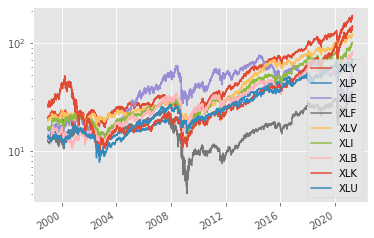

In [3]:
PRICE.plot(logy=True)

In [5]:
RET.corr()

,XLY,XLP,XLE,XLF,XLV,XLI,XLB,XLK,XLU
XLY,1.000000,0.630839,0.550128,0.757087,0.698219,0.818478,0.719970,0.721404,0.510392
XLP,0.630839,1.000000,0.476845,0.578389,0.619895,0.634416,0.564292,0.490231,0.600913
XLE,0.550128,0.476845,1.000000,0.579287,0.510116,0.661217,0.688774,0.474002,0.513969
XLF,0.757087,0.578389,0.579287,1.000000,0.632805,0.786986,0.690180,0.630380,0.503352
XLV,0.698219,0.619895,0.510116,0.632805,1.000000,0.714383,0.604887,0.678794,0.541036
XLI,0.818478,0.634416,0.661217,0.786986,0.714383,1.000000,0.809568,0.729918,0.556697
XLB,0.719970,0.564292,0.688774,0.690180,0.604887,0.809568,1.000000,0.588919,0.509414
XLK,0.721404,0.490231,0.474002,0.630380,0.678794,0.729918,0.588919,1.000000,0.461934
XLU,0.510392,0.600913,0.513969,0.503352,0.541036,0.556697,0.509414,0.461934,1.000000


Get SPY as benchmark:

In [4]:
spy = tiingo.get_dataframe(['SPY'], '1999-1-1', metric_name='adjClose')
spy.index = pd.to_datetime(spy.index).tz_convert(None)
spy[-3:]

,SPY
2021-04-14,411.45
2021-04-15,415.87
2021-04-16,417.26


Backtest function:

In [6]:
def get_rebalance_dates(frequency, start_date):
    price = PRICE[PRICE.index>start_date]
    group = getattr(price.index, frequency) 
    return price[:1].index.union(price.groupby([price.index.year, group]).tail(1).index)



def compare_performance(t):
    t.add(1).cumprod().plot()
    t.add(1).cumprod().plot(logy=True)

    annual_returns = t[:'2020'].add(1).resample('A').prod().sub(1)
    r_annual_Tbill = RATES.Treasury_1.resample('A').first()

    x = pd.DataFrame()                        
    x['Average_returns']   = annual_returns.mean()
    x['Geometric_average'] = annual_returns.add(1).prod().pow(1/len(annual_returns)).sub(1)
    x['Risk_premium']      = annual_returns.sub(r_annual_Tbill, 'rows').dropna().mean()
    x['Volatility']        = t[:'2020'].std() * 252**0.5    
    x['Sharpe_ratio']      = x.Risk_premium / x.Volatility

    return x




def run_backtest(frequency, backtest_start='1900-1-1'):   
    
    rebalance_dates = get_rebalance_dates(frequency, backtest_start) 

    portfolio_value = pd.Series(1,                        index=[rebalance_dates[0]])    
    weights         = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])
    trades          = pd.DataFrame(columns=PRICE.columns, index=[rebalance_dates[0]])

    previous_positions = weights.iloc[0]
        
    for i in range(1, len(rebalance_dates)-1):
        start_date = rebalance_dates[i]
        end_date   = rebalance_dates[i+1]

        cum_ret = RET[start_date:end_date][1:].add(1).cumprod()
                
        start_weights = select_weights(start_date)      # Call "select_weights()" function to get the weights
            
        new_positions = portfolio_value.iloc[-1] * start_weights   

        start_to_end_positions = new_positions  * cum_ret
        start_to_end_value     = start_to_end_positions.sum('columns')

        portfolio_value = portfolio_value.append(start_to_end_value) 
                
        weights = weights.append(start_to_end_positions.div(start_to_end_value,'rows'))                 
                
        trades.loc[start_date] = new_positions - previous_positions 
        previous_positions     = start_to_end_positions.iloc[-1]      # Previous positions for the next rebalance round

    return portfolio_value.pct_change(), weights, trades

Backstest strategy that equal-weights all assets:

In [9]:
pd.Series(0.5, index = ['XLK','XLF'])

XLK    0.5
XLF    0.5
dtype: float64

In [13]:
pd.Series(1 / len(sectors), index = sectors)

XLY    0.111111
XLP    0.111111
XLE    0.111111
XLF    0.111111
XLV    0.111111
XLI    0.111111
XLB    0.111111
XLK    0.111111
XLU    0.111111
dtype: float64

In [14]:
pd.Series( 1 / len(sectors), index = PRICE.columns)

XLY    0.111111
XLP    0.111111
XLE    0.111111
XLF    0.111111
XLV    0.111111
XLI    0.111111
XLB    0.111111
XLK    0.111111
XLU    0.111111
dtype: float64

In [17]:
def select_weights(date):            
    return   pd.Series(1 / len(sectors), index = sectors)


ew, weights, trades = run_backtest('month','2000-1-1')
ew = ew.rename('EW')

t = pd.DataFrame(ew).join(spy.pct_change())
t

,EW,SPY
2000-01-03,NaN,-0.009787
2000-02-01,0.007537,0.009852
2000-02-02,0.002602,0.000887
2000-02-03,-0.000994,0.015064
2000-02-04,-0.002668,-0.004147
...,...,...
2021-04-12,0.001409,0.000365
2021-04-13,0.001725,0.002964
2021-04-14,0.002567,-0.003415
2021-04-15,0.007535,0.010742


,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
EW,0.091669,0.078461,0.072226,0.189818,0.380502
SPY,0.082703,0.067384,0.063260,0.198243,0.319105


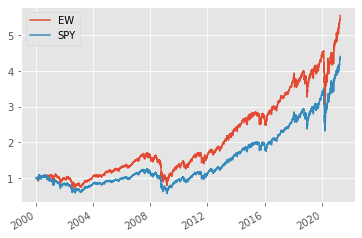

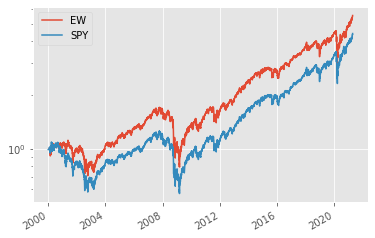

In [18]:
compare_performance(t)

Minimum volatilty weights:

,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
MinVol,0.082771,0.075506,0.063328,0.144292,0.438889
EW,0.091669,0.078461,0.072226,0.189818,0.380502
SPY,0.082703,0.067384,0.063260,0.198243,0.319105


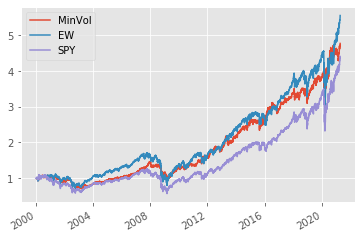

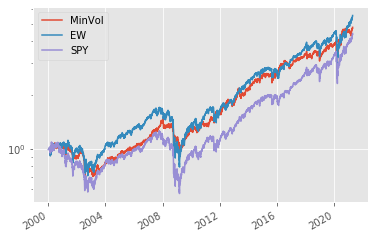

In [19]:
def select_weights(date):   
    cov     = RET[:date][-100:].cov() * 252          # Use most recent 100 returns up to currrent date.
    cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
    w = cov_inv.sum() /  cov_inv.sum().sum()         # Minimum-volatility portfolio.       
    return w  


mv, weights, trades = run_backtest('month','2000-1-1')
mv = mv.rename('MinVol')

t = pd.DataFrame(mv).join(ew).join(spy.pct_change())
compare_performance(t)

Plot the weights:

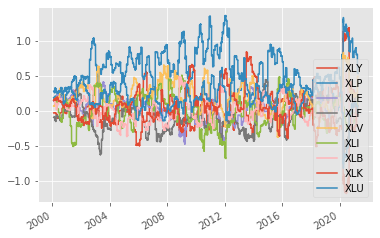

In [20]:
weights.plot()

Most recent weights:

In [22]:
weights.sum('columns')

2000-01-03    0.0
2000-02-01    1.0
2000-02-02    1.0
2000-02-03    1.0
2000-02-04    1.0
             ... 
2021-04-12    1.0
2021-04-13    1.0
2021-04-14    1.0
2021-04-15    1.0
2021-04-16    1.0
Length: 5337, dtype: float64

In [24]:
weights.iloc[-1]

XLY    0.072872
XLP    0.529767
XLE   -0.040834
XLF    0.066179
XLV    0.490574
XLI    0.198291
XLB   -0.225021
XLK   -0.053631
XLU   -0.038197
Name: 2021-04-16 00:00:00, dtype: float64

In [25]:
weights.iloc[-1].sum()

1.0000000000000002

In [27]:
weights.iloc[-1].clip(0)

XLY    0.072872
XLP    0.529767
XLE    0.000000
XLF    0.066179
XLV    0.490574
XLI    0.198291
XLB    0.000000
XLK    0.000000
XLU    0.000000
Name: 2021-04-16 00:00:00, dtype: float64

In [28]:
weights.iloc[-1].clip(0).sum()

1.3576819411282899

In [29]:
weights.iloc[-1].clip(0) / weights.iloc[-1].clip(0).sum()

XLY    0.053674
XLP    0.390200
XLE    0.000000
XLF    0.048744
XLV    0.361332
XLI    0.146051
XLB    0.000000
XLK    0.000000
XLU    0.000000
Name: 2021-04-16 00:00:00, dtype: float64

Add this to our select_weights function:

,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
MinVol,0.082771,0.075506,0.063328,0.144292,0.438889
All_MinVol_Clipped,0.083318,0.073950,0.063876,0.154724,0.412835
EW,0.091669,0.078461,0.072226,0.189818,0.380502
SPY,0.082703,0.067384,0.063260,0.198243,0.319105


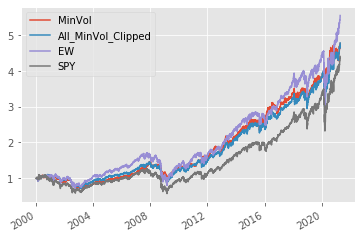

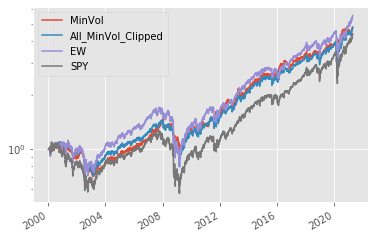

In [30]:
def select_weights(date):   
    cov     = RET[:date][-100:].cov() * 252          # Use most recent 100 returns up to currrent date.
    cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
    w = cov_inv.sum() /  cov_inv.sum().sum()         # Minimum-volatility portfolio.   
    w =  w.clip(0) / w.clip(0).sum()
    return w  


mv_clipped, weights, trades = run_backtest('month' , '2000-1-1')
mv_clipped = mv_clipped.rename('All_MinVol_Clipped')

t = pd.DataFrame(mv).join(mv_clipped).join(ew).join(spy.pct_change())
compare_performance(t)

Install [cvxopt](https://cvxopt.org/) library for constrained optimization:

In [31]:
pip install CVXOPT

     |████████████████████████████████| 3.1 MB 4.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [32]:
import cvxopt
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

Now use the cvxopt like this:

In [36]:
minimum_weight = 0.05

cov = RET.cov()


n = len(cov)
P = matrix(  cov.values )
q = matrix(  np.zeros(n) )
G = matrix( -np.identity(n) )
h = matrix( -np.ones(n)*minimum_weight)
A = matrix(  np.ones(n), (1,n))         
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)

pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})

XLY    0.050103
XLP    0.525974
XLE    0.050062
XLF    0.050027
XLV    0.065815
XLI    0.050101
XLB    0.050092
XLK    0.050134
XLU    0.107692
dtype: float64

Compare clipped weights to constrained minimum:

In [37]:
weights = pd.DataFrame()

# Min-vol, no constraints

cov     = RET.cov() 
cov_inv = pd.DataFrame(np.linalg.inv(cov), columns=cov.columns, index=cov.index)
w = cov_inv.sum() /  cov_inv.sum().sum()  

weights['Min_vol'] = w

# Min-vol, clipped at zero:       
w = w.clip(0) / w.clip(0).sum() 

weights ['Clipped'] = w


# Constrained minimum:

minimum_weight = 0 
cov = RET.cov()

n = len(cov)
P = matrix( cov.values )
q = matrix( np.zeros(n) )
G = matrix( -np.identity(n) ) 
h = matrix( -np.ones(n)*minimum_weight)
A = matrix( np.ones(n), (1,n)) 
b = matrix(1.0)

sol = solvers.qp(P, q, G, h, A, b)

weights['Constrained'] = pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})
weights

,Min_vol,Clipped,Constrained
XLY,0.022653,0.018975,0.000192
XLP,0.622874,0.521757,0.608226
XLE,-0.016520,0.000000,0.000149
XLF,-0.176621,0.000000,0.000010
XLV,0.276593,0.231691,0.224172
XLI,0.048820,0.040895,0.000244
XLB,0.039986,0.033495,0.000618
XLK,-0.000660,0.000000,0.000348
XLU,0.182875,0.153187,0.166042


Put this code into the select weights function:

,Average_returns,Geometric_average,Risk_premium,Volatility,Sharpe_ratio
MinVol,0.082771,0.075506,0.063328,0.144292,0.438889
All_MinVol_Clipped,0.083318,0.073950,0.063876,0.154724,0.412835
MinVol_cvxopt,0.074977,0.066212,0.055534,0.146711,0.378528
EW,0.091669,0.078461,0.072226,0.189818,0.380502
SPY,0.082703,0.067384,0.063260,0.198243,0.319105


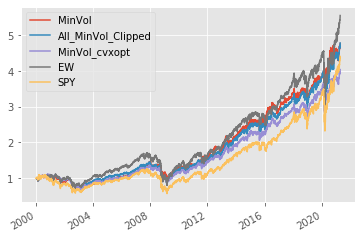

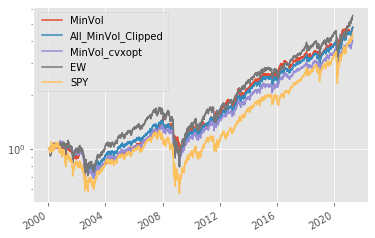

In [40]:
def select_weights(date):   
    
    minimum_weight = 0 
    cov = RET[:date][-100:].cov()

    n = len(cov)
    P = matrix( cov.values )
    q = matrix( np.zeros(n) )
    G = matrix( -np.identity(n) ) 
    h = matrix( -np.ones(n)*minimum_weight)
    A = matrix( np.ones(n), (1,n)) 
    b = matrix(1.0)

    sol = solvers.qp(P, q, G, h, A, b)

    w = pd.Series({cov.index[i]:sol['x'][i] for i in range(n)})
    
    return w


mv_cvxopt, weights, trades = run_backtest('month', '2000-1-1')
mv_cvxopt = mv_cvxopt.rename('MinVol_cvxopt')

t = pd.DataFrame(mv).join(mv_clipped).join(mv_cvxopt).join(ew).join(spy.pct_change())
compare_performance(t)